In [4]:

import nengo
import numpy as np
import time

import tkinter as tk
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from nengo_extras.data import one_hot_from_labels
from nengo_extras.matplotlib import tile
from nengo_extras.vision import Gabor, Mask

import threading
import queue
import pickle
import nengo_dl
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)
from sklearn.model_selection import train_test_split


import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

In [5]:
%pip install --user protobuf==3.20.0

Note: you may need to restart the kernel to use updated packages.


In [3]:
input_width = 160
input_height = 60
n_hid = 1000

lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('./input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup


x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('./input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('./input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('./input/leapgestrecog/leapGestRecog/0' + 
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((input_width, input_height))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
x_data = x_data / 255 * 2 - 1
print(x_data.shape)
#x_data = x_data.reshape(datacount, -1)

y_data = np.array(y_data)
y_data = y_data.reshape(datacount)


(20000, 60, 160)


In [6]:
with open("reverseloopup.pkl", "wb") as outp:
    pickle.dump(reverselookup, outp, pickle.HIGHEST_PROTOCOL)

In [5]:
x_data = x_data.reshape((x_data.shape[0], 1, -1))
y_data = y_data.reshape((y_data.shape[0], 1, -1))
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2, random_state=42)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5, random_state=42)


In [17]:
print(x_data.shape)

(20000, 1, 784)


In [6]:
def preprocess_img_cnn_nengo(img, width=160, height =60) :


    img = img.reshape((1, 1, -1))


    tiled_test_images = np.tile(img, (1, 30, 1))
    return tiled_test_images

(1, 30, 9600)


In [38]:
def predict_img_cnn_nengo(nengo_converter, nengo_input, nengo_output, tiled_test_images, params_file = "keras_to_snn_big_params") :
 
        with nengo_dl.Simulator(
                nengo_converter.net, minibatch_size=1, progress_bar=False
        ) as nengo_sim:
                nengo_sim.load_params(params_file)
                data = nengo_sim.predict({nengo_input: tiled_test_images})
                
        predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
        return predictions
    

In [35]:
def load_nengo_cnn(tiled_test_images, params_file = "keras_to_snn_params") :
    # input
    inp = tf.keras.Input(shape=(input_height, input_width, 1))

    # convolutional layers
    conv0 = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=3,
        activation=tf.nn.relu,
    )(inp)

    conv1 = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=3,
        strides=2,
        activation=tf.nn.relu,
    )(conv0)

    # fully connected layer
    flatten = tf.keras.layers.Flatten()(conv1)
    dense = tf.keras.layers.Dense(units=10)(flatten)

    model = tf.keras.Model(inputs=inp, outputs=dense)

    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
        scale_firing_rates=100,
        synapse=0.01,
    )

    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    
        

    return nengo_converter, nengo_input, nengo_output

    

In [39]:
tiled_test_images = preprocess_img_cnn_nengo(x_data[3])
nengo_converter, nengo_input, nengo_output = load_nengo_cnn(tiled_test_images)
prediction = predict_img_cnn_nengo(nengo_converter, nengo_input, nengo_output, tiled_test_images)

(1, 1, 9600)


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


In [40]:
print(prediction)

[1]


In [41]:
tiled_test_images = preprocess_img_cnn_nengo(x_data[12544])

prediction = predict_img_cnn_nengo(nengo_converter, nengo_input, nengo_output, tiled_test_images)

(1, 1, 9600)
1/1 [==============================] - 2s 2s/step


In [7]:
class NengoCNNPredictor:
    def __init__(self, params_file="keras_to_snn_big_params"):
        self.params_file = params_file
        self.loaded = False
        self.nengo_converter = None
        self.nengo_input = None
        self.nengo_output = None
        self.nengo_sim = None

    def load_model(self):
        if not self.loaded:
            # Define the model architecture
            # input
            inp = tf.keras.Input(shape=(input_height, input_width, 1))

            # convolutional layers
            conv0 = tf.keras.layers.Conv2D(
                filters=32,
                kernel_size=3,
                activation=tf.nn.relu,
            )(inp)

            conv1 = tf.keras.layers.Conv2D(
                filters=64,
                kernel_size=3,
                strides=2,
                activation=tf.nn.relu,
            )(conv0)

            # fully connected layer
            flatten = tf.keras.layers.Flatten()(conv1)
            dense = tf.keras.layers.Dense(units=10)(flatten)

            model = tf.keras.Model(inputs=inp, outputs=dense)

            nengo_converter = nengo_dl.Converter(
                model,
                swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
                scale_firing_rates=100,
                synapse=0.01,
            )

            nengo_input = nengo_converter.inputs[inp]
            nengo_output = nengo_converter.outputs[dense]

            # Convert the model to Nengo
            self.nengo_converter = nengo_dl.Converter(
                model,
                swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
                scale_firing_rates=100,
                synapse=0.01,
            )

            self.nengo_input = self.nengo_converter.inputs[inp]
            self.nengo_output = self.nengo_converter.outputs[dense]

            with self.nengo_converter.net:
                nengo_dl.configure_settings(stateful=False)

            self.loaded = True

    def load_simulator(self):
        if not self.loaded:
            self.load_model()

        self.nengo_sim = nengo_dl.Simulator(self.nengo_converter.net, minibatch_size=1, progress_bar=False)
        self.nengo_sim.load_params(self.params_file)

    def predict(self, tiled_test_images):
        if self.nengo_sim is None:
            self.load_simulator()

        data = self.nengo_sim.predict({self.nengo_input: tiled_test_images})
        #print(data[self.nengo_output][:, -1].shape)
        #plt.subplot(1, 1, 1)  # Use a single subplot
        #plt.title("Output predictions")
        #plt.plot(tf.nn.softmax(data[self.nengo_output][0]))
        #plt.legend([str(j) for j in range(10)], loc="upper left")
        #plt.xlabel("Timestep")
        #plt.ylabel("Probability")

        predictions = np.argmax(data[self.nengo_output][:, -1], axis=-1)
        return predictions



In [9]:
predictor = NengoCNNPredictor()

In [14]:
img = preprocess_img_cnn_nengo(x_test[0])
predictions = predictor.predict(img)

1/1 [==============================] - 1s 1s/step


In [8]:
y_pred = np.empty((1))

predictor = NengoCNNPredictor()



for element in x_test :
    img = preprocess_img_cnn_nengo(element)
    predictions = predictor.predict(img)
  
    y_pred = np.concatenate((y_pred, predictions), axis=0)
    

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


KeyboardInterrupt: 

In [21]:
print(y_pred.shape)
print(y_test.shape)

(2001,)
(2000, 1, 1)


In [22]:
print(y_pred)
y_pred1 = y_pred[1:]


[6.95305994e-310 9.00000000e+000 3.00000000e+000 ... 7.00000000e+000
 9.00000000e+000 5.00000000e+000]


In [23]:
y_test1 = y_test.reshape(-1)

In [44]:
print(y_test1.shape)

(2000,)


In [10]:
from sklearn.metrics import confusion_matrix

In [24]:
print(y_pred1.shape)
print(y_test1.shape)

(2000,)
(2000,)


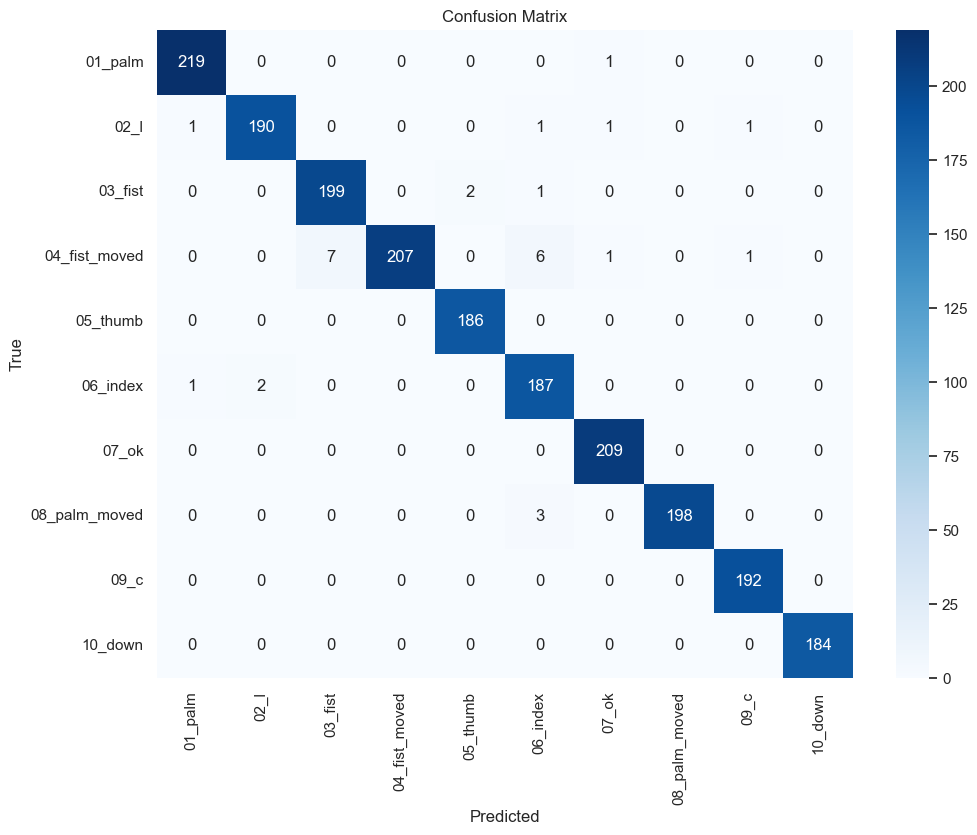

In [25]:

y_pred_classes = y_pred1
y_true = y_test1
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=reverselookup.values(),
            yticklabels=reverselookup.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
from sklearn.metrics import precision_score, recall_score

def f2_score(y_true, y_pred):
    # Assuming y_true and y_pred are binary (0 or 1) arrays

    # Calculate precision and recall
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Set beta for F2 score
    beta = 2

    # Calculate F2 score
    f2 = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

    return f2

In [27]:
print(f2_score(y_test1, y_pred1))

0.9860540905105358


(1, 30, 9600)
1/1 [==============================] - 2s 2s/step
(1, 10)
[1]


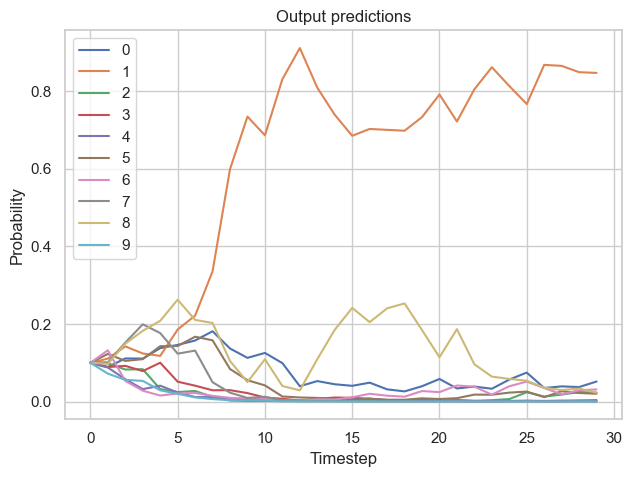

In [10]:
# Example usage:
predictor = NengoCNNPredictor()
tiled_test_images = preprocess_img_cnn_nengo(x_data[12544])
print(tiled_test_images.shape)
predictions = predictor.predict(tiled_test_images)
print(predictions)

In [48]:
tiled_test_images = preprocess_img_cnn_nengo(x_data[12])
predictions = predictor.predict(tiled_test_images)
print(predictions)

(1, 1, 9600)
1/1 [==============================] - 1s 1s/step
[0]


In [13]:
tiled_test_images = preprocess_img_cnn_nengo(x_data[1])
nengo_sim, nengo_input, nengo_output = load_nengo_cnn()
prediction = predict_img_cnn_nengo(nengo_sim, nengo_input, nengo_output, tiled_test_images)

(1, 1, 9600)


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\nengo_dl\simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


SimulatorClosed: Cannot call predict after simulator is closed

In [12]:
def run_network(
    activation,
    params_file="keras_to_snn_big_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    # add a probe to the first convolutional layer to record activity.
    # we'll only record from a subset of neurons, to save memory.
    sample_neurons = np.linspace(
        0,
        np.prod(conv0.shape[1:]),
        1000,
        endpoint=False,
        dtype=np.int32,
    )
    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons])

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(x_test[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == y_test[:n_test, 0, 0]).mean()
    print(f"Test accuracy: {100 * accuracy:.2f}%")

    # plot the results
    for ii in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Input image")
        plt.imshow(x_test[ii, 0].reshape((60, 160)), cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        scaled_data = data[conv0_probe][ii] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")
        plt.xlabel("Timestep")
        plt.title(
            f"Neural activities (conv0 mean={rates.mean():.1f} Hz, "
            f"max={rates.max():.1f} Hz)"
        )
        plt.plot(scaled_data)

        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][ii]))
        plt.legend([str(j) for j in range(10)], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")

        plt.tight_layout()